In [66]:
# %pip install xgboost
# %pip install seaborn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from IPython.core.display import Image
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

Aprendizado semi-supervisionado.

In [67]:
from sklearn.neighbors import NearestNeighbors

def defineUnlabeledPoints(X_true, y_true, clusters):
    # cosine 55%
    # l2 57%
    y_true = y_true.reset_index(drop=True)
    metric='euclidean'
    # Achando os negativos mais proximos
    n_neighbors = len(clusters[0])
    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric=metric)
    nn.fit(clusters[0])

    true_negatives_indices = y_true.index[(y_true == 0).all(axis=1)]
    true_negatives = X_true.iloc[true_negatives_indices, :]
    true_negatives = true_negatives.mean(axis=0).values.reshape(1, -1)

    distances, indices = nn.kneighbors(true_negatives)
    distances_mean = sum(distances[0])/len(distances[0])
    mask = distances < distances_mean
    indices = indices[mask]
    nearest_negatives = clusters[0].iloc[indices.ravel(), :]

    # Achando os positivos mais proximos
    n_neighbors = len(clusters[1])
    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric=metric)
    nn.fit(clusters[1])

    true_positives_indices = y_true.index[(y_true == 1).all(axis=1)]
    true_positives = X_true.iloc[true_positives_indices, :]
    true_positives = true_positives.mean(axis=0).values.reshape(1, -1)

    distances, indices = nn.kneighbors(true_positives)
    distances_mean = sum(distances[0])/len(distances[0])
    mask = distances < distances_mean
    indices = indices[mask]
    nearest_positives = clusters[1].iloc[indices.ravel(), :]

    X_unlabeled = pd.DataFrame(nearest_negatives.iloc[0:1, :])
    X_unlabeled = np.concatenate((X_unlabeled, nearest_positives.iloc[0:1, :]), axis=0)
    min_length = min(len(nearest_negatives), len(nearest_positives))

    for i in range(1, min_length):
        X_unlabeled = np.concatenate((X_unlabeled, nearest_negatives.iloc[i: i+1, :]), axis=0)
        X_unlabeled = np.concatenate((X_unlabeled, nearest_positives.iloc[i: i+1, :]), axis=0)

    if len(nearest_negatives) > min_length:
        X_unlabeled = np.concatenate((X_unlabeled, nearest_negatives.iloc[min_length:, :]), axis=0)
    elif len(nearest_positives) > min_length:
        X_unlabeled = np.concatenate((X_unlabeled, nearest_positives.iloc[min_length:, :]), axis=0)

    X_unlabeled = pd.DataFrame(X_unlabeled)
    return X_unlabeled

def trainClassifier(X_labeled, y_labeled, clusters, clf, k, print_accuracy=False):
    kf = KFold(n_splits=k)
    empirical_losses = []
    test_losses = []
    empirical_accuracies = []
    test_accuracies = []

    for i, (train_indices, test_indicies) in enumerate(kf.split(X_labeled)):
        print(f"kfold: {i+1}")
        print(f"Train indices: {train_indices}")
        print(f"Test indices: {test_indicies}")
        X_train, X_test = X_labeled.iloc[train_indices], X_labeled.iloc[test_indicies]
        y_train, y_test = y_labeled.iloc[train_indices], y_labeled.iloc[test_indicies]
        unlabeled_points = defineUnlabeledPoints(X_train, y_train, clusters)
        
        batch_size = 10
        repeats = unlabeled_points.shape[0] // batch_size
        last_accuracy = 0.0
        for i in range(0, repeats):
            clf.fit(X_train, y_train) # classificador generico
            accuracy = clf.score(X_test, y_test)

            if accuracy < last_accuracy:
                # remove the last batch from X_train and y_train
                rows = X_train.shape[0]
                X_train = X_train.iloc[0:rows - batch_size, :]
                y_train = y_train.iloc[0:rows - batch_size, :]
                continue
            
            last_accuracy = accuracy

            print(f"    {i/repeats*100: .2f}%... | Accuracy on batch {i + 1}: {accuracy * 100: .2f}%")

            delta_X_batch = pd.DataFrame(unlabeled_points.iloc[i*batch_size : batch_size*(i+1), :])
            delta_y_batch = pd.DataFrame(clf.predict(delta_X_batch))

            X_train = pd.concat([X_train, delta_X_batch], axis=0)
            y_train = pd.concat([y_train, delta_y_batch], axis=0)

        empirical_loss = log_loss(y_train, clf.predict(X_train))
        test_loss = log_loss(y_test, clf.predict(X_test))

        empirical_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)

        empirical_losses.append(empirical_loss)
        test_losses.append(test_loss)

        empirical_accuracies.append(empirical_accuracy)
        test_accuracies.append(test_accuracy)

    empirical_loss = np.mean(empirical_losses)
    test_loss = np.mean(test_losses)

    empirical_accuracy = np.mean(empirical_accuracies) * 100
    test_accuracy = np.mean(test_accuracies) * 100

    if print_accuracy:
        print()
        print(f"empirical_accuracy: {empirical_accuracy: .2f}% | test_accuracy: {test_accuracy: .2f}% ")

    return (empirical_loss, test_loss)

data = pd.read_csv('data.csv')

X_questions = data.iloc[:, 2:182] # Id e data de nascimento são irrelevantes
X_questions = X_questions.drop('date_visit', axis=1) # Data de visita não é relevante
X_questions = X_questions.drop(X_questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

X_drugs = data.iloc[:, 185:]
X_drugs = X_drugs.drop(X_drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1) # Essas colunas são constantes

X_random = np.random.rand(X_questions.shape[0], 1) # Para comparar a perfomance do modelo

# Codificando as variáveis categóricas
le = LabelEncoder()
for col in X_questions.columns:
    if X_questions[col].dtype == 'bool':
        X_questions[col] = le.fit_transform(X_questions[col])

for col in X_drugs.columns:
    if X_drugs[col].dtype == 'bool':
        X_drugs[col] = le.fit_transform(X_drugs[col])

# Imputando os valores que faltam
imp = SimpleImputer(strategy='mean')
imp.fit(X_questions)
X_questions = imp.transform(X_questions)

imp = SimpleImputer(strategy='mean')
imp.fit(X_drugs)
X_drugs = imp.transform(X_drugs)

# Normalizando os dados
scaler = StandardScaler()
X_drugs = scaler.fit_transform(X_drugs)
X_questions = scaler.fit_transform(X_questions)
X_random = scaler.fit_transform(X_random)

X_questions = pd.DataFrame(X_questions)
X_drugs = pd.DataFrame(X_drugs)
X_random = pd.DataFrame(X_random)

Y = data.iloc[:, 182:185]

y_vas30 = Y.iloc[:, 0:1].values.ravel()
y_vas50 = Y.iloc[:, 1:2].values.ravel()
y_gic = Y.iloc[:, 2:3].values.ravel()

y_perceived = np.logical_and(y_vas30, y_vas50)
y_perceived = y_perceived.astype(int)

y = np.logical_and(y_perceived, y_gic)
y = y.astype(int)
y = pd.DataFrame(y)
    
one_rows = pd.DataFrame(y.index[(y == 1).all(axis=1)]) # Achando os indices das linhas que tem y=1
zero_rows = pd.DataFrame( y.index[(y == 0).all(axis=1)]) # Achando os indices das linhas que tem y=0
zero_rows = zero_rows.sample(n=one_rows.shape[0], random_state=1)
print(zero_rows.index.tolist()) # selected indices

# LABELED DATA
X_questions_labeled = X_questions.iloc[one_rows[0].tolist() + zero_rows[0].tolist(), :].astype(int)
X_drugs_labeled = X_drugs.iloc[one_rows[0].tolist() + zero_rows[0].tolist(), :].astype(int)
X_labeled = np.concatenate((X_questions_labeled, X_drugs_labeled), axis=1).astype(int) # A junção das duas tabelas

X_questions_labeled = pd.DataFrame(X_questions_labeled)
X_drugs_labeled = pd.DataFrame(X_drugs_labeled)
X_labeled = pd.DataFrame(X_labeled)

y_labeled = y.iloc[one_rows[0].tolist() + zero_rows[0].tolist(), :].astype(int)
y_labeled = pd.DataFrame(y_labeled)

# UNLABELED DATA
X_questions_unlabeled = X_questions.drop(index=X_questions_labeled.index)
X_drugs_unlabeled = X_drugs.drop(index=X_drugs_labeled.index)
X_unlabeled = np.concatenate((X_questions_unlabeled, X_drugs_unlabeled), axis=1) # A junção das duas tabelas
y_unlabeled = y.drop(index=y_labeled.index)

X_questions_unlabeled = pd.DataFrame(X_questions_unlabeled)
X_drugs_unlabeled = pd.DataFrame(X_drugs_unlabeled)
X_unlabeled = pd.DataFrame(X_unlabeled)
y_unlabeled = pd.DataFrame(y_unlabeled)

# SHUFFLE
X_questions_labeled = X_questions_labeled.reset_index(drop=True)
X_drugs_labeled = X_drugs_labeled.reset_index(drop=True)
X_labeled = X_labeled.reset_index(drop=True)
y_labeled = y_labeled.reset_index(drop=True)

random_state = 42
indices = y_labeled.index.tolist()
shuffled_indices = pd.DataFrame(indices).sample(frac=1, random_state=random_state).values.ravel()
X_questions_labeled = X_questions_labeled.iloc[shuffled_indices, :]
X_drugs_labeled = X_drugs_labeled.iloc[shuffled_indices, :]
X_labeled = X_labeled.iloc[shuffled_indices, :]
y_labeled = y_labeled.iloc[shuffled_indices, :]

# random_state = 42 # set a random state for reproducibility
# indices = X_questions_labeled.index.tolist() # get the indices of the dataframes
# shuffled_indices = pd.DataFrame(indices).sample(frac=1, random_state=random_state).values.ravel() # shuffle the indices

# X_questions_labeled = X_questions_labeled.loc[shuffled_indices, :] # sort X_questions_labeled by the shuffled indices
# X_drugs_labeled = X_drugs_labeled.loc[shuffled_indices, :] # sort X_drugs_labeled by the shuffled indices
# X_labeled = X_labeled.loc[shuffled_indices, :] # sort X_labeled by the shuffled indices
# y_labeled = y_labeled.loc[shuffled_indices, :] # sort y_labeled by the shuffled indices

n_clusters = 2
# model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None)
# model.fit(X_unlabeled)

# Z = linkage(X_unlabeled, method='ward')
# plt.figure(figsize=(10, 5)) # plot the dendrogram
# dendrogram(Z, truncate_mode='lastp', p=n_clusters)
# # plt.show()

# labels = model.labels_
# unique_labels = np.unique(labels)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100, max_iter=300)
labels = kmeans.fit_predict(X_unlabeled)
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(X_unlabeled.iloc[i:i+1, :])
    # clusters[label] = clusters[label].append(X_unlabeled.iloc[i:i+1, :])
    
for key in clusters.keys():
    clusters[key] = pd.concat(clusters[key])

old_value0 = clusters[0]
old_value1 = clusters[1]

clusters[0] = old_value1
clusters[1] = old_value0

clf = xgb.XGBClassifier(max_depth=7,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)

X_labeled = X_labeled.iloc[indices]
clf = trainClassifier(X_labeled, y_labeled, clusters, clf, 5, True)

Gráfico de convergencia com aumento de exemplos

Selecting  8.97% of the indices
Selecting  10.26% of the indices
Selecting  10.26% of the indices
Selecting  10.26% of the indices
Selecting  10.26% of the indices
Selecting  11.54% of the indices
Selecting  11.54% of the indices
Selecting  11.54% of the indices
Selecting  12.82% of the indices
Selecting  12.82% of the indices
Selecting  14.10% of the indices
Selecting  14.10% of the indices
Selecting  15.38% of the indices
Selecting  15.38% of the indices
Selecting  16.67% of the indices
Selecting  17.95% of the indices
Selecting  19.23% of the indices
Selecting  19.23% of the indices
Selecting  20.51% of the indices
Selecting  23.08% of the indices
Selecting  24.36% of the indices
Selecting  26.92% of the indices
Selecting  28.21% of the indices
Selecting  32.05% of the indices
Selecting  34.62% of the indices
Selecting  39.74% of the indices
Selecting  44.87% of the indices
Selecting  52.56% of the indices
Selecting  61.54% of the indices
Selecting  76.92% of the indices
Selecting  

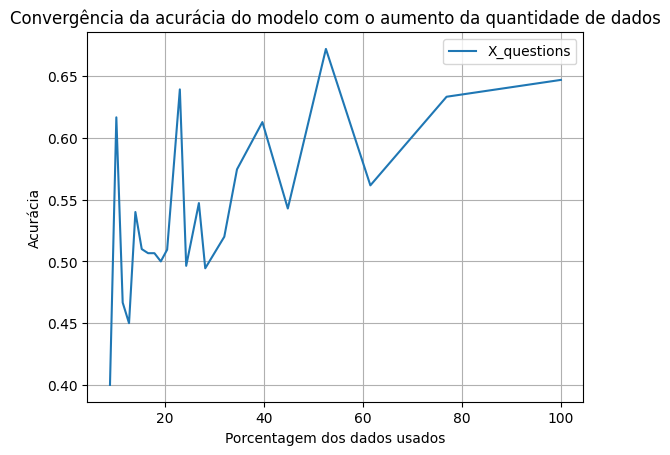

In [68]:
from sklearn.neighbors import NearestNeighbors

xs = []
ys_1 = []
ys_2 = []
ys_3 = []
ys_4 = []

for i in np.arange(10, 0, -0.3):
    data = pd.read_csv('data.csv')

    X_questions = data.iloc[:, 2:182] # Id e data de nascimento são irrelevantes
    X_questions = X_questions.drop('date_visit', axis=1) # Data de visita não é relevante
    X_questions = X_questions.drop(X_questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

    X_drugs = data.iloc[:, 185:]
    X_drugs = X_drugs.drop(X_drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                            142,143,148,151,152]], axis=1) # Essas colunas são constantes

    X_random = np.random.rand(X_questions.shape[0], 1) # Para comparar a perfomance do modelo

    # Codificando as variáveis categóricas
    le = LabelEncoder()
    for col in X_questions.columns:
        if X_questions[col].dtype == 'bool':
            X_questions[col] = le.fit_transform(X_questions[col])

    for col in X_drugs.columns:
        if X_drugs[col].dtype == 'bool':
            X_drugs[col] = le.fit_transform(X_drugs[col])

    # Imputando os valores que faltam
    imp = SimpleImputer(strategy='mean')
    imp.fit(X_questions)
    X_questions = imp.transform(X_questions)

    imp = SimpleImputer(strategy='mean')
    imp.fit(X_drugs)
    X_drugs = imp.transform(X_drugs)

    # Normalizando os dados
    scaler = StandardScaler()
    X_drugs = scaler.fit_transform(X_drugs)
    X_questions = scaler.fit_transform(X_questions)
    X_random = scaler.fit_transform(X_random)

    X_questions = pd.DataFrame(X_questions)
    X_drugs = pd.DataFrame(X_drugs)
    X_random = pd.DataFrame(X_random)
    X = pd.concat([X_questions, X_drugs], axis=1)

    Y = data.iloc[:, 182:185]

    y_vas30 = Y.iloc[:, 0:1].values.ravel()
    y_vas50 = Y.iloc[:, 1:2].values.ravel()
    y_gic = Y.iloc[:, 2:3].values.ravel()

    y_perceived = np.logical_and(y_vas30, y_vas50)
    y_perceived = y_perceived.astype(int)

    y = np.logical_and(y_perceived, y_gic)
    y = y.astype(int)
    y = pd.DataFrame(y)
    

    one_rows = pd.DataFrame(y.index[(y == 1).all(axis=1)]) # Achando os indices das linhas que tem y=1
    zero_rows = pd.DataFrame( y.index[(y == 0).all(axis=1)]) # Achando os indices das linhas que tem y=0
    zero_rows = zero_rows.sample(n=one_rows.shape[0], random_state=3)

    last_index = int(one_rows.shape[0]/i)
    percentage = (last_index)/(one_rows.shape[0])*100
    print(f"Selecting {percentage: .2f}% of the indices")
    one_rows = one_rows[0:last_index]
    zero_rows = zero_rows[0:last_index]

    indices = pd.concat([one_rows, zero_rows]).values.ravel() # Concatenando os indices das linhas que tem y=1 e y=0
    X_questions = X_questions.iloc[indices, :]
    X_drugs = X_drugs.iloc[indices, :]
    X = X.iloc[indices, :]
    X_random = X_random.iloc[indices, :]
    y = y.iloc[indices, :]

    X_questions = X_questions.reset_index(drop=True)
    X_drugs = X_drugs.reset_index(drop=True)
    X = X.reset_index(drop=True)
    X_random = X_random.reset_index(drop=True)
    y = y.reset_index(drop=True)

    clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                                colsample_bytree=0.8, scale_pos_weight=1)

    if percentage > 100:
        break

    xs.append(percentage)

    clf.fit(X_questions, y)
    score = cross_val_score(clf, X_questions, y, cv=5, scoring='accuracy').mean()
    ys_1.append(score)

    # clf.fit(X_drugs, y)
    # score = cross_val_score(clf, X_drugs, y, cv=5, scoring='accuracy').mean()
    # ys_2.append(score)    

    # clf.fit(X, y)
    # score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
    # ys_3.append(score)

    # clf.fit(X_random, y)
    # score = cross_val_score(clf, X_random, y, cv=5, scoring='accuracy').mean()
    # ys_3.append(score)

plt.plot(xs, ys_1)
# plt.plot(xs, ys_2)
# plt.plot(xs, ys_3)
plt.title('Convergência da acurácia do modelo com o aumento da quantidade de dados')
# plt.legend(['X_questions', 'X_drugs', 'X_random'])
plt.legend(['X_questions'])
plt.grid()
plt.xlabel('Porcentagem dos dados usados')
plt.ylabel('Acurácia')
plt.show()
# inices
# X_labeled = X_labeled.iloc[indices]
# clf = trainClassifier(X_labeled, y_labeled, clusters, clf, 5, True)